# Plots for section 5

In [ ]:
#TODO: Try to replicate some plots from Ruhnau Paper (have another look at it)

### Imports

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd

from utils import market_values, market_values_links, market_values_by_time_index, market_values_links_con, congestion_rent_link, convert_ISO_3166_2_to_1, generation, generation_links, market_values_storage_units, generation_storage_units

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, capacity_storage_units, get_condense_sum

# imported own definitions
from utils import carrier_colors, carrier_renaming, resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal

# general variables
font1 = {'fontname':'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

In [2]:
# Network imports
n_no =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
n_h2 =pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# Notebook Definitions

c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger", "solar thermal"]

In [4]:
# Notebook Functions

def get_df(df_no, df_h2, carriers):
    result = pd.DataFrame(index = ["no H2 network", "H2 network"])

    for c in carriers:
        result.loc["no H2 network" , c] = df_no[c].values
        result.loc["H2 network" , c] = df_h2[c].values
    return result

In [5]:
# Regions

onshore_regions['coords'] = onshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
onshore_regions['coords'] = [coords[0] for coords in onshore_regions['coords']]
onshore_regions["name"] = onshore_regions.index
offshore_regions['coords'] = offshore_regions['geometry'].apply(lambda x: x.representative_point().coords[:])
offshore_regions['coords'] = [coords[0] for coords in offshore_regions['coords']]
offshore_regions["name"] = offshore_regions.index

### General
- round trip efficiency of hydrogen and batter storage (grafik mit power point machen) strom -> electrolyse -> storage -> fuel cell -> strom


In [6]:
n_no.links[n_no.links.carrier == "H2 Electrolysis"].efficiency.unique() # Electrolysis: 68 % efficiency
n_no.links[n_no.links.carrier == "H2 Fuel Cell"].efficiency.unique() # Fuel Cell: 50 % efficiency
n_no.links[n_no.links.carrier == "battery charger"].efficiency.unique() # Fuel Cell: 0.979796 efficiency
n_no.links[n_no.links.carrier == "battery discharger"].efficiency.unique() # Fuel Cell: 0.979796 efficiency

# storage losses?

array([0.9797959])

![](../../../../Pictures/Screenshots/Screenshot_20230219_110123.png)
Colbertado

### Capacity

In [7]:
cap_no = pd.DataFrame(index=n_no.buses.location.unique())
cap_h2 = pd.DataFrame(index=n_h2.buses.location.unique())

for n, df in zip([n_no, n_h2], [cap_no,cap_h2]):

    for c in n.generators.carrier.unique():
        # capacity in GW
        df[c] = capacity(n, c) / 1000

    for c in n.links.carrier.unique():
        # capacity in GW
        df[c] = capacity_links(n, c) / 1000

    for c in n.storage_units.carrier.unique():
        # capacity in GW
        df[c] = capacity_storage_units(n, c) / 1000

# condense groups
cap_no = get_condense_sum(cap_no, c1_groups, c1_groups_name)
cap_h2 = get_condense_sum(cap_h2, c1_groups, c1_groups_name)
# rename unhandy column names
cap_no.rename(columns=carrier_renaming, inplace=True)
cap_h2.rename(columns=carrier_renaming, inplace=True)
# take sum
cap_no_sum = pd.DataFrame(cap_no.sum().sort_values(ascending=False)).transpose()
cap_h2_sum = pd.DataFrame(cap_h2.sum().sort_values(ascending=False)).transpose()

In [8]:
# electrolyzer capcity
carriers = ["H2 Electrolysis"]
get_df(cap_no_sum, cap_h2_sum, carriers)

,H2 Electrolysis
no H2 network,1290.869609
H2 network,1082.971374


In [9]:
# H2 storage capcity
index_h2stores_no = n_no.stores[n_no.stores.carrier == "H2"].index

In [10]:
n_no.stores[n_no.stores.carrier == "H2"]

,bus,carrier,e_nom_extendable,e_cyclic,capital_cost,e_initial,e_min_pu,e_nom,e_nom_max,lifetime,...,e_nom_opt,type,e_nom_min,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
DE0 0 H2 Store,DE0 0 H2,H2,True,True,140.161529,0.0,0.0,0.0,3.257629e+06,inf,...,5.008064e+05,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 11 H2 Store,DE0 11 H2,H2,True,True,140.161529,0.0,0.0,0.0,3.464642e+08,inf,...,1.257958e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 15 H2 Store,DE0 15 H2,H2,True,True,140.161529,0.0,0.0,0.0,8.861846e+08,inf,...,1.833548e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 21 H2 Store,DE0 21 H2,H2,True,True,140.161529,0.0,0.0,0.0,2.866523e+07,inf,...,1.258530e+06,,0.0,1.0,False,True,0.0,0.0,1.0,0
DE0 23 H2 Store,DE0 23 H2,H2,True,True,140.161529,0.0,0.0,0.0,1.576804e+08,inf,...,5.705198e+05,,0.0,1.0,False,True,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 H2 Store,SE3 5 H2,H2,True,True,4117.636382,0.0,0.0,0.0,inf,inf,...,8.884398e+02,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE3 6 H2 Store,SE3 6 H2,H2,True,True,4117.636382,0.0,0.0,0.0,inf,inf,...,1.235597e+03,,0.0,1.0,False,True,0.0,0.0,1.0,0
SE3 7 H2 Store,SE3 7 H2,H2,True,True,4117.636382,0.0,0.0,0.0,inf,inf,...,5.896688e+02,,0.0,1.0,False,True,0.0,0.0,1.0,0


In [11]:
# Optimised nominal energy capacity outputed by OPF.
df = n_no.stores.e_nom_opt[index_h2stores_no]
df.index = df.index.map(n_no.stores.bus).map(n_no.buses.location)
onshore_regions["h2_cap_no"] = df

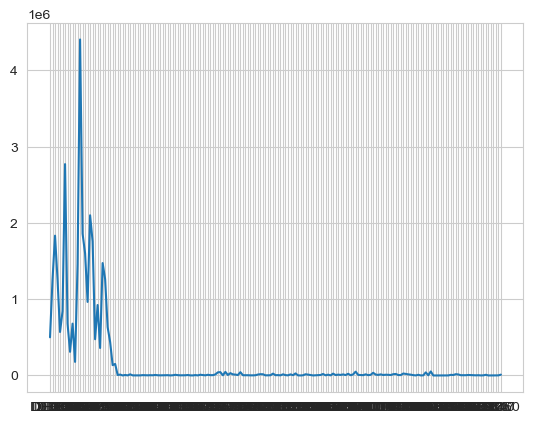

In [12]:
plt.plot(df)

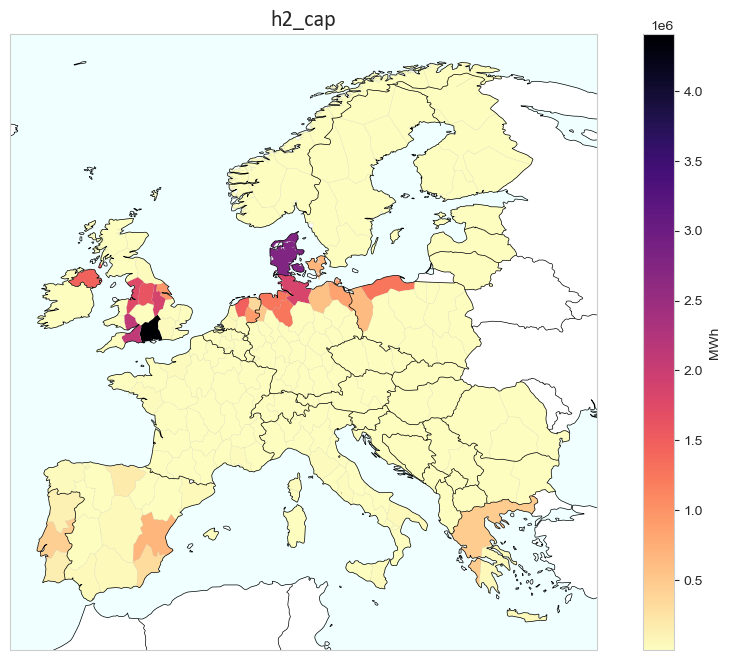

In [13]:
fig = plt.figure(figsize=(12, 8))
crs = ccrs.EqualEarth()

ax = plt.axes(projection=ccrs.EqualEarth())
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.coastlines(edgecolor='black', linewidth=0.5)
ax.set_facecolor('white')
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.set_title("h2_cap", fontsize=16, **font1)

onshore_regions.to_crs(crs.proj4_init).plot(column="h2_cap_no",
                     ax=ax,
                     cmap=plt.get_cmap("magma_r"),
                     linewidth=0.05,
                     edgecolor = 'grey',
                     legend=True,
                     legend_kwds={'label':"MWh",
                        'orientation': "vertical"})

plt.show()

In [14]:
# Why are the hydrogen capacities located there?
# calc Correlation with wind, solar and other power plant capacity (e.g.

### Generation

In [15]:
# how long are the electrolyzers running
# load duration curve
# capacity factors
# pie chart of which electricity (from which source?) is used for electrolysers (is that possible)

![](../../../../Pictures/Screenshots/Screenshot_20230215_163455.png)

In [16]:
# get generation of all carriers
gen_no = pd.DataFrame(index=n_no.generators_t.p.index)
gen_h2 = pd.DataFrame(index=n_h2.generators_t.p.index)

for n, gen in zip([n_no, n_h2], [gen_no, gen_h2]):

    for carrier in n.generators.carrier.unique():
        gen[carrier]= n.generators_t.p.loc[:, n.generators.carrier == carrier].mean(axis=1)

    for carrier in n.links.carrier.unique():
        gen[carrier]= abs(n.links_t.p1.loc[:, n.links.carrier == carrier]).mean(axis=1)

    for carrier in n.storage_units.carrier.unique():
        gen[carrier]= n.storage_units_t.p.loc[:, n.storage_units.carrier == carrier].mean(axis=1)

gen_no.head()
gen_h2.head()

,offwind-ac,onwind,solar,ror,offwind-dc,gas,residential rural solar thermal,services rural solar thermal,residential urban decentral solar thermal,services urban decentral solar thermal,...,H2 liquefaction,Fischer-Tropsch,process emissions,process emissions CC,DAC,electricity distribution grid,home battery charger,home battery discharger,hydro,PHS
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,268.143083,5551.771185,0.000000,131.480149,1923.417507,42693.291964,0.000000,0.000000,0.000000,0.000000,...,317.139904,649.639484,0.002220,1576.712107,0.002791,3663.660671,0.080187,0.078689,165.861003,-39.680649
2013-01-01 03:00:00,204.310567,5229.187357,0.000000,131.814111,1728.979883,42737.576537,0.000000,0.000000,0.000000,0.000000,...,317.139904,649.639501,0.002212,1576.712108,0.002648,3714.621554,0.077781,0.081399,166.498494,25.564299
2013-01-01 06:00:00,208.301047,4918.666102,693.716771,133.240706,2045.517347,42809.069444,0.000010,0.000009,0.000016,0.000014,...,317.139904,649.639476,0.002210,1576.712108,0.002701,4096.516148,0.079776,0.079938,4.149153,-203.035320
2013-01-01 09:00:00,192.722434,4370.152534,3400.242546,135.214357,2282.299700,42837.916349,0.002005,0.001966,0.002839,0.002707,...,317.139904,649.639559,0.002207,1576.712108,0.002841,4350.784532,0.086951,0.073144,4.129062,-563.707456
2013-01-01 12:00:00,198.327351,4309.124022,2756.980878,138.019046,2510.954302,42911.830920,0.002984,0.002702,0.005925,0.004024,...,317.139904,649.639437,0.002201,1576.712109,0.002847,4216.609612,0.088634,0.071517,4.319208,-439.550813


<Figure size 1000x600 with 0 Axes>

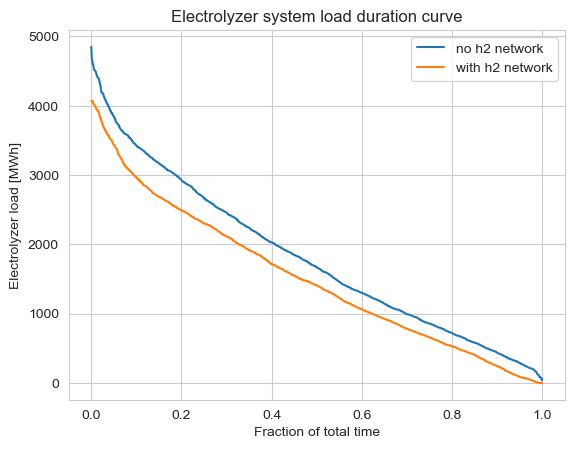

In [17]:
# why is this in a whole other magnitude than capacity?
# does sorting the whole df make sense? shouldtn the be sorted seperately?

df = pd.DataFrame(gen_no["H2 Electrolysis"].sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
df["H2 Electrolysis no h2"] = pd.DataFrame(gen_h2["H2 Electrolysis"].sort_values(ascending=False)).set_index(pd.Index(np.linspace(0, 1, num=2920)))
df.columns = ["no h2 network","with h2 network" ]

plt.figure(figsize=(10, 6))
df.plot()
plt.title("Electrolyzer system load duration curve")
plt.ylabel("Electrolyzer load [MWh]")
plt.xlabel("Fraction of total time")
plt.legend()
plt.show()

### Storage Behavior

#### Feed-in and feed-out pattern

In [18]:
# Energy as calculated by the OPF.
n.stores_t.p[index_h2stores].sum(axis=1).plot()
plt.show()

NameError: name 'index_h2stores' is not defined

#### Storage level over time

In [ ]:
# Energy as calculated by the OPF.
n.stores_t.e[index_h2stores].sum(axis=1).plot()
plt.show()

In [ ]:
# storage level of 10 largest stores
index = n.stores.e_nom_opt[index_h2stores].sort_values(ascending=False).head(10).index

# yearly plot
for store in index:
    fig, ax = plt.subplots()
    n.stores_t.e[store].plot(ax=ax, ylabel=store)

## Ideas:
- Calc capacity factors / system load duration curves for electrolysis in different regions and try to investigate in differences (amount of wind generation, solar) Is only excess electrolysis consumed by electrolysis?
- Try to determine connection between electrolysis and excess solar / wind production
- Try to determine percent / amount of excess electricity that is used to produce hydrogen. (Basically all energy from renewables that went into electrolysis?)
- pie chart of percentage of electricity that is used directly, used for Electrolysis, battery, ... (startup script)
- Reproduce graph from Victoria, Zhu et al. 2019 – The role of storage technologies (in hydrogen word document); try to find patterns within the charging of battery and the charging with hydrogen (electrolysis -> fuel cell)
-